In [14]:
par_log_transform = True

In [15]:
import numpy as np

import numpy.linalg as LA
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from utils.my_plotting_lib import plot_conf_ellipse

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams["mathtext.fontset"] = "stix"

rc('axes', titlesize=15)
rc('axes', labelsize=12)

In [16]:
with np.load('results/fsp_solutions.npz', allow_pickle=True) as fsp_sol_file:
    rna_distributions = fsp_sol_file['rna_distributions']
    rna_sensitivities = fsp_sol_file['rna_sensitivities']
    t_meas = fsp_sol_file['t_meas']

with np.load('results/fim_flowcyt.npz', allow_pickle=True) as f:
    flowcyt_prob = f['flowcyt_prob']
    
with np.load('results/flowcyt_pars.npz') as f:
    kappa=f['kappa']
    sigma_probe=f['sigma_probe']
    mu_bg=f['mu_bg']
    sigma_bg=f['sigma_bg']

with np.load('results/bursting_parameters.npz') as par:
    k_on = par['kon']
    k_off = par['koff']
    k_r = par['kr']
    gamma = par['gamma']

theta = np.array([k_on, k_off, k_r, gamma])

In [17]:
fim_single_cell = dict()

with np.load('results/fim_exact.npz') as data:
    fim_single_cell['exact'] = data['fim_exact']
    
with np.load('results/fim_lowres.npz') as data:
    fim_single_cell['lowres'] = data['fim_lowres']         

with np.load('results/fim_flowcyt.npz') as data:
    fim_single_cell['flowcyt'] = data['fim_flowcyt']

if par_log_transform:
    for fim in fim_single_cell.values():
        for it in range(0, len(t_meas)):
            for i in range(0,4):
                for j in range(0,4):
                    fim[it, i, j] *= theta[i]*theta[j]*np.log(10)*np.log(10)

In [18]:
with np.load('results/flowcyt_C_matrix.npz') as file:
    C_flowcyt=file['C_flowcyt']
    yeval = file['yeval']
    xmax_flowcyt= file['xmax']    
    
with np.load('results/lowres_C_matrix.npz') as file:
    C_lowres = file['C_lowres']
    xmax_lowres = file['xmax']
    ymax_lowres = file['ymax']    

In [19]:
ncells_smfish = 1000
ncells_flowcyt = 10000
nfish_mix = 500
nflow_mix = 5000
fim_mix = np.zeros((len(t_meas), 4, 4))

for it in range(0, len(t_meas)):
    fim_mix[it,:,:] = nfish_mix*fim_single_cell['lowres'][it] + nflow_mix*fim_single_cell['flowcyt'][it]      

fim_multi_cells = dict()
fim_multi_cells['mix'] = fim_mix 

for meas_type in fim_single_cell.keys():    
    fim_multi_cells[meas_type] = ncells_smfish*fim_single_cell[meas_type]
fim_multi_cells['flowcyt'] = ncells_flowcyt*fim_single_cell['flowcyt']
 
def compute_combined_fim(fim_array, dt, num_times):
    t_idx = dt*np.linspace(1, num_times, num_times, dtype=int)
    fim = fim_array[t_idx[0], :, :]
    for i in range(1, len(t_idx)):
        fim += fim_array[t_idx[i], :, :]
    return fim

num_times = 5
dt_min = 1
dt_max = int(np.floor(t_meas[-1]/num_times))
dt_array = np.linspace(dt_min, dt_max, dt_max - dt_min +1, dtype=int)

fim_multi_cells_times = dict()
det_fim_multi_cells_times = dict()

for meas_type in fim_multi_cells.keys():
    combined_fim = np.zeros((len(dt_array), 4, 4))
    det_comb_fim = np.zeros((len(dt_array),))
    
    for i in range(0, len(dt_array)):
        combined_fim[i, :, :] = compute_combined_fim(fim_multi_cells[meas_type], dt_array[i],  num_times)           
        det_comb_fim[i] = np.linalg.det(combined_fim[i,:,:])
        
    fim_multi_cells_times[meas_type] = combined_fim 
    det_fim_multi_cells_times[meas_type] = det_comb_fim 

In [20]:
opt_rates = dict()
for meas in fim_multi_cells_times.keys():
    opt_rates[meas] = np.argmax(det_fim_multi_cells_times[meas])

30
28
22


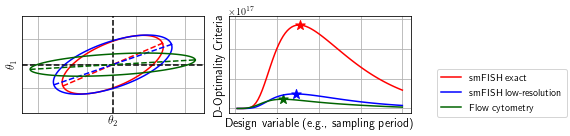

In [36]:
labels = {
        'exact': f'smFISH exact',
        'lowres': f'smFISH low-resolution',
        'flowcyt': f'Flow cytometry',
}

colors = {
        'exact': f'red',
        'lowres': f'blue',
        'flowcyt': f'darkgreen',
}
    
fig, axs = plt.subplots(1,2)
fig.set_size_inches(6, 2)
fig.set_tight_layout(True)
for meas in ['exact', 'lowres', 'flowcyt']:
    idx_opt = opt_rates[meas]
    fims = fim_multi_cells_times[meas]
    dets = det_fim_multi_cells_times[meas]

    print(idx_opt)
        
    plot_conf_ellipse(fims[idx_opt], 3, 
                      axs[0], [1,0], theta, colors[meas], '')    
    
    axs[1].plot(dt_array, dets, label=labels[meas], color=colors[meas])
    axs[1].scatter(dt_array[idx_opt], dets[idx_opt],
               100,
               color=colors[meas], marker='*')


axs[0].set_aspect('equal', 'datalim')    
axs[0].set_ylabel(r'$\theta_1$')    
axs[0].set_xlabel(r'$\theta_2$')

h, l = axs[1].get_legend_handles_labels()
fig.legend(h, l, bbox_to_anchor=(1, 0.1, 1, 0.7), loc='lower left')
# axs[2].set_xlim([0, 60])
axs[1].set_xlabel('Design variable (e.g., sampling period)')
axs[1].set_ylabel('D-Optimality Criteria')

for ax in list(axs):
    ax.grid()
    ax.tick_params(
            axis='both',
            which='both',
            bottom=False,
            top=False,
            labelbottom=False,
            left=False,
            labelleft=False
    )
    
fig.savefig('figs/abs_fim_dopt.png', bbox_inches='tight', dpi=300)

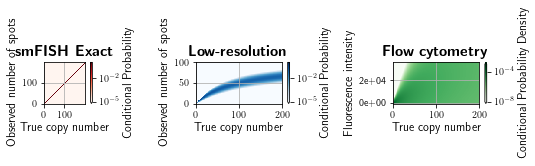

In [22]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(8, 2)
fig.set_tight_layout(True)

import matplotlib.colors as colors

C_exact = np.eye(201)

C_exact[C_exact<=0.0] = 1.0e-16
p0 = axs[0].imshow(C_exact[0:200,0:200], norm=colors.LogNorm(vmin=1.0E-5, vmax=1.0),
                         cmap=plt.cm.get_cmap("Reds"), origin='lower')
fig.colorbar(p0, ax=axs[0], orientation='vertical', extend='min', label=r"Conditional Probability")

C_lowres[C_lowres == 0.0] = 1.0e-16
p1 = axs[1].pcolormesh(C_lowres[0:200,0:200], norm=colors.LogNorm(vmin=1.0E-5, vmax=1.0),
                         cmap=plt.cm.get_cmap("Blues"))
axs[1].set_ylim([0, 100])
fig.colorbar(p1, ax=axs[1], orientation='vertical', extend='min', label="Conditional Probability")

p2 = axs[2].pcolormesh(np.arange(0, 201), yeval, C_flowcyt, norm=colors.LogNorm(vmin=1.0E-8, vmax=1.0E-3),
                         cmap=plt.cm.get_cmap("Greens"))
axs[2].yaxis.set_major_formatter(FormatStrFormatter('%.0e'))
cbar2 = fig.colorbar(p2, ax=axs[2], orientation='vertical', extend='both', label=r"Conditional Probability Density")


for j in range(0,3):
    axs[j].set_xlabel('True copy number')
    axs[j].set_ylabel('Observed number of spots')
axs[2].set_ylabel('Fluorescence intensity')    

models = ['smFISH Exact', 'Low-resolution', 'Flow cytometry']
for j in range(0,3):
    axs[j].set_title(rf'\textbf{{{models[j]}}}')
    axs[j].grid()
    
fig.savefig('figs/abs_kernel_maps.png', bbox_inches='tight', dpi=400)

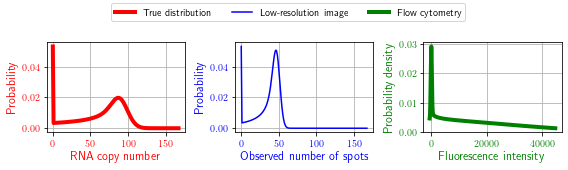

In [23]:
fig, axs = plt.subplots(1,3)
fig.set_tight_layout(True)
fig.set_size_inches(8,2)
itime = 60
xmax = len(rna_distributions[itime])-1
p_lowres = C_lowres[0:xmax+1, 0:xmax+1]@rna_distributions[itime]
    
axs[0].plot(np.arange(0, xmax+1), rna_distributions[itime], color='red', label='True distribution', linewidth=4)
axs[0].set_xlabel('RNA copy number', color='red')
axs[0].tick_params(axis='both', labelcolor='red')
axs[0].set_ylabel('Probability', color='red')

axs[1].plot(np.arange(0, xmax+1), p_lowres, color='blue', label='Low-resolution image')
axs[1].set_xlabel('Observed number of spots', color='blue')
axs[1].tick_params(axis='both', labelcolor='blue')
axs[1].set_ylabel('Probability', color='blue')
   
axs[2].plot(flowcyt_prob[itime]['yeval'], flowcyt_prob[itime]['peval']*kappa, 
        color='green', linestyle='-', label='Flow cytometry', linewidth=4)
axs[2].tick_params(axis='both', labelcolor='green')
axs[2].set_ylabel('Probability density', color='green')
axs[2].set_xlabel('Fluorescence intensity', color='green')

for ax in list(axs):
    ax.grid()    

fig.legend(bbox_to_anchor=(0,1,1,1), loc='lower center', ncol=3)
fig.savefig('figs/abs_distorted_dists.pdf', bbox_inches='tight')


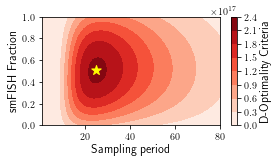

In [35]:
with np.load('results/fim_multifi.npz') as file:
    fim_multifi = file['fim_multifi']
    p_grid = file['p_grid']
    dt_array = file['dt_array']

dopt_landscape = np.zeros((fim_multifi.shape[0], fim_multifi.shape[1]))    
for i in range(dopt_landscape.shape[0]):
    for j in range(dopt_landscape.shape[1]):
        dopt_landscape[i, j] = np.linalg.det(fim_multifi[i, j, :, :])

idx_max = np.argmax(dopt_landscape)
[imax, jmax] = np.unravel_index(idx_max, dopt_landscape.shape)

import matplotlib.colors as colors
fig, ax = plt.subplots(1,1)
fig.set_size_inches(4,2)
multifi_heatmap = ax.contourf(dt_array, p_grid, dopt_landscape, cmap=plt.cm.get_cmap("Reds"))
ax.scatter(dt_array[jmax], p_grid[imax], 100,  color='yellow', marker='*', norm=colors.LogNorm())
ax.set_xlabel(r'Sampling period')
ax.set_ylabel('smFISH Fraction')
fig.colorbar(multifi_heatmap, ax=ax, extend='both', label='D-Optimality Criteria')
fig.savefig('figs/abs_fim_multifi_heatmap.pdf', bbox_inches='tight')